<a href="https://colab.research.google.com/github/Ishan130803/Semantic-Segmentation-Cityscapes/blob/main/CityScape_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Console Simulator

In [ ]:
sys.path

['/content',
 '/env/python',
 '/usr/lib/python310.zip',
 '/usr/lib/python3.10',
 '/usr/lib/python3.10/lib-dynload',
 '',
 '/usr/local/lib/python3.10/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.10/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/cityscapesScripts']

In [ ]:
import sys
# sys.path.append('/content/cityscapesScripts')
sys.path.

In [ ]:
! git clone https://github.com/mcordts/cityscapesScripts

Cloning into 'cityscapesScripts'...
remote: Enumerating objects: 648, done.
remote: Counting objects: 100% (221/221), done.
remote: Compressing objects: 100% (64/64), done.
remote: Total 648 (delta 184), reused 165 (delta 155), pack-reused 427
Receiving objects: 100% (648/648), 796.28 KiB | 3.46 MiB/s, done.
Resolving deltas: 100% (370/370), done.


In [ ]:
import os
os.

In [ ]:
!cd cityscapesScripts
!cd sample_data
!ls
# !python setup.py

cityscapesScripts  sample_data


# Prerequisite Installation

In [ ]:
! pip install remotezip

In [ ]:
! python -m pip install cityscapesscripts cityscapesscripts[gui]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.6/473.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.1/338.1 kB 33.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.9/59.9 MB 11.5 MB/s eta 0:00:00
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26306 sha256=6a1db9fc764b54259f706919af3be2d38d2f84195e8b23e6aca39f98b2d37e8a
  Stored in directory: /root/.cache/pip/wheels/7c/d0/9e/1f26ebb66d9e1732e4098bc5a6c2d91f6c9a529838f0284890
Successfully built typing


# Imports

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

# Dataset

## Initializing Session Object

In [ ]:
import cityscapesscripts

In [ ]:
from cityscapesscripts.download import downloader

In [ ]:
session = downloader.login()

Cityscapes username or email address: ishansrivastava_it22a9_35@dtu.ac.in
Cityscapes password: ··········
Store credentials unencrypted in '/root/.local/share/cityscapesscripts/credentials.json' [y/N]: n


## RemoteZip Approach

In [ ]:
import requests
import zipfile
import io
from remotezip import RemoteZip
import threading, multiprocessing
import concurrent.futures
import time

class DataExplorer:
    def __init__(
            self,
            name : str = "",
            url : str = "",
            session : requests.sessions.Session | None = None,
    ):
        self.name = name
        self.url = url
        self.session = session
        self.files_list = []
        self.cache_list = []

    def _check_files_list(self):
        if not self.files_list:
            self.files_list = self.get_file_contents()

    def get_filtered_list(self,filter,start = None,end = None,**kwargs):
        self._check_files_list()
        return [f for f in self.files_list if filter(f)][start:end]

    def download_with_filter(
            self,
            filter,
            destination_path : str = "",
            **kwargs

    ):
        self._check_files_list()
        self.cache_list = self.get_filtered_list(filter,**kwargs)
        self.download_listed_files(self.cache_list,destination_path=destination_path)

    def download_with_filter_parallel(
            self,
            filter,
            destination_path : str = "",
            **kwargs

    ):
        self._check_files_list()
        self.cache_list = self.get_filtered_list(filter,**kwargs)
        return self.download_in_parallel(self.cache_list,destination_path=destination_path,**kwargs)


    def get_file_contents(self):
        """
        returns list of file contents
        url : url of the zip file
        """
        with RemoteZip(self.url, session = self.session) as z:
            zip_contents = z.namelist()
            return sorted(zip_contents);

    def download_listed_files(
        self,file_list : list[str] | str,
        destination_path : str = "",
    ):
        """
        file_list : list of files to be extracted
        """

        with RemoteZip(self.url,session = self.session) as z:
            for file in file_list:
                try:
                    z.extract(file,destination_path)
                    print(f"Task {file} downloaded succesfully")
                except Exception as e:
                    print(f"Task {file} generated an exception: {e}")

    def download_in_parallel(
            self,file_list : list[str] | str,
            destination_path : str = "",
            rate = 200,
            **kwargs
    ):
        """
        file_list : list of files to be extracted
        url : url of the zip file
        """
        count = 0
        semaphore = multiprocessing.Semaphore(rate)
        lock = multiprocessing.Lock()
        logs = multiprocessing.Array('i', [0,0,0])
        def _extract(z,file_name,destination_path,logs, *args):
            retries = 3
            while retries:
                with semaphore:
                    try:
                        z.extract(file_name,destination_path,*args)
                        with logs.get_lock():
                            logs[0] += 1
                            # print(f"Task {file_name} downloaded succesfully")
                        return
                    except Exception as e:
                        with logs.get_lock():
                            # print(f"Task {file_name} generated an exception: {e}")
                            # print(f"Retrying... {retries} retry remaining")
                            logs[2] += 1
                        time.sleep(0.01)
                    retries -= 1
            with logs.get_lock():
                logs[2] += 1

        with RemoteZip(self.url,session = self.session) as z:
            processes = []

            for file in file_list:
                process = multiprocessing.Process(target=_extract, args=(z,file,destination_path,logs))
                processes.append(process)
                process.start()
                # time.sleep(0.01)


            for thread in processes:
                thread.join()

            stats = {
                "Success" : logs[0],
                "Fails" : logs[1],
                "retries" : logs[2]
            }
            return stats


### Initialization of downloader objects

In [ ]:
class dobj:
    gtfine_data = DataExplorer(
        url = "https://www.cityscapes-dataset.com/file-handling/?packageID=1",
        session=session,
        name="gtfine"
    )
    leftimg = DataExplorer(
        url = "https://www.cityscapes-dataset.com/file-handling/?packageID=3",
        session=session,
        name="leftimg"
    )
    rightimg = DataExplorer(
        url = "https://www.cityscapes-dataset.com/file-handling/?packageID=5",
        session=session,
        name="rightimg"
    )

### Downloading

In [ ]:
dobj.gtfine_data.download_with_filter_parallel(
    filter = lambda x : x,
    destination_path = "",
    rate = 9999,
)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Process Process-5475:
Process Process-5466:
Process Process-5467:


In [ ]:
dobj.leftimg.get_file_contents()

## Direct Download

In [ ]:
from cityscapesscripts.download import downloader

In [ ]:
# view datasets
downloader.list_available_packages(session = session)

The following packages are available for download.
Please refer to https://www.cityscapes-dataset.com/downloads/ for additional packages and instructions on properly citing third party packages.
 gtFine_trainvaltest.zip -> 241MB
 gtCoarse.zip -> 1.3GB
 leftImg8bit_trainvaltest.zip -> 11GB
 leftImg8bit_trainextra.zip -> 44GB
 rightImg8bit_trainvaltest.zip -> 11GB
 rightImg8bit_trainextra.zip -> 44GB
 disparity_trainvaltest.zip -> 3.5GB
 disparity_trainextra.zip -> 15GB
 camera_trainvaltest.zip -> 2MB
 camera_trainextra.zip -> 8MB
 vehicle_trainvaltest.zip -> 2MB
 vehicle_trainextra.zip -> 7MB
 leftImg8bit_demoVideo.zip -> 6.6GB
 all_demoVideo.zip -> 59GB
 leftImg8bit_blurred.zip -> 11GB
 leftImg8bit_sequence_trainvaltest.zip -> 324GB
 timestamp_sequence.zip -> 40MB
 vehicle_sequence.zip -> 56MB
 rightImg8bit_sequence_trainvaltest.zip -> 322GB
 disparity_sequence_trainvaltest.zip -> 106GB
 leftImg8bit_allFrames_frankfurt.zip -> 241GB
 timestamp_allFrames_frankfurt.zip -> 29MB
 vehicle_al

In [ ]:
# Saving name of datasets in variables
images_dataset = 'leftImg8bit_trainvaltest.zip'
segmentation_dataset = 'gtFine_trainvaltest.zip'

In [ ]:
downloader.download_packages(
    session = session,
    package_names=[
        images_dataset,
        segmentation_dataset,
    ],
    destination_path = '/content/',
    resume = True,
)

Download progress:  98%|█████████▊| 10.8G/11.0G [03:44<00:04, 51.7MB/s]


Download progress: 100%|█████████▉| 241M/241M [00:04<00:00, 59.1MB/s]


## Extraction

In [ ]:
import zipfile
import multiprocessing

class Extracter:
    def __init__(
            self,
            path : str = ""
    ):
        self.path = path
        self.files_list = None

    def _check_files_list(self):
        if not self.files_list :
            self.files_list = self.get_files_list()

    def extract_with_filter(
            self,
            filter,
            destination_path : str = ""
    ):
        self._check_files_list()
        temp = [f for f in self.files_list if filter(f)]
        return self.extract_listed_files(
            temp,destination_path
        )

    def extract_listed_files(self, files_to_extract, destination_path = ""):
        self._check_files_list()
        lock = multiprocessing.Lock()
        arr = multiprocessing.Array('i',[0,0,0])
        def _extract(z,file_name,destination_path,arr, *args):
            retries = 3
            while retries:
                try:
                    z.extract(file_name,destination_path,*args)
                    with arr.get_lock():
                        arr[0]+=1
                        # print(f"Task {file_name} extracted succesfully")
                    return
                except Exception as e:
                    retries -= 1
                    with arr.get_lock():
                        # print(f"Task {file_name} generated an exception: {e}")
                        arr[1] += 1
            with arr.get_lock():
                arr[2] += 1
        processes = []
        with zipfile.ZipFile(self.path, 'r') as zip_ref:
            # List all files in the zip
            all_files = zip_ref.namelist()

            for file in files_to_extract:
                pr = multiprocessing.Process(target = _extract, args = [zip_ref,file,destination_path,arr])
                processes.append(pr)
                pr.start()

            for pr in processes:
                pr.join()
        return {
            "success" : arr[0],
            "retries" : arr[1],
            "fail" : arr[2]
        }

    def extract_all(self):
        with zipfile.ZipFile(self.path,'r') as z:
            z.extractall()

    def get_files_list(self):
        with zipfile.ZipFile(self.path,'r') as z:
            return sorted(z.namelist())

In [ ]:
class exObj:
    segments = Extracter('/content/gtFine_trainvaltest.zip')
    images = Extracter('/content/leftImg8bit_trainvaltest.zip')

In [ ]:
# exObj.segments.extract_with_filter(
#     filter = lambda x : x,
# )

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
exObj.images.extract_all()
exObj.segments.extract_all()

In [ ]:
import cv2
arr = cv2.imread('/content/gtFine/test/bielefeld/bielefeld_000000_000321_gtFine_color.png')

In [ ]:
arr.max()

0

In [ ]:
arr.min()

0

In [ ]:
arr.max()

0

# Data Exploration

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import threading

def display_images_in_grid(image_paths, grid_size):
    """
    Display images in a grid.

    Parameters:
    image_paths (list): List of image file paths.
    grid_size (tuple): Number of rows and columns in the grid.
    """
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(15, 10))
    axes = axes.flatten()
    lock = threading.Lock()
    img_arr = [None] * len(image_paths)
    def get_arr(i):
        img = mpimg.imread(image_paths[i])
        # with lock:
        img_arr[i] = img

    threads = []
    for i, img_path in enumerate(image_paths):
        th = threading.Thread(target = get_arr, args = [i])
        threads.append(th)
        th.start()
    for th in threads:
        th.join()

    # print(image_paths)

    for ax,arr in zip(axes,img_arr):
        ax.imshow(arr)
        ax.axis('off')
    # Hide remaining axes if there are fewer images than grid cells
    for ax in axes[len(image_paths):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
_ = cv2.imread('gtFine/test/berlin/berlin_000000_000019_gtFine_color.png')
cv2_imshow(_)

In [ ]:
path_lists.image_file_names[10:13]

['rightImg8bit/test/berlin/berlin_000006_000019_rightImg8bit.png',
 'rightImg8bit/test/berlin/berlin_000007_000019_rightImg8bit.png',
 'rightImg8bit/test/berlin/berlin_000008_000019_rightImg8bit.png']

In [ ]:
_ = leftimg.get_filtered_list(
    lambda x : x.startswith('leftImg8bit/train/') and x.endswith('.png'),
    start = 5, end = 10
    )

In [ ]:
_ = leftimg.download_with_filter(
    lambda x : x.startswith('leftImg8bit/train/') and x.endswith('.png'),
    start = 5, end = 10
    )

Task leftImg8bit/train/aachen/aachen_000005_000019_leftImg8bit.png downloaded succesfully
Task leftImg8bit/train/aachen/aachen_000006_000019_leftImg8bit.png downloaded succesfully
Task leftImg8bit/train/aachen/aachen_000007_000019_leftImg8bit.png downloaded succesfully
Task leftImg8bit/train/aachen/aachen_000008_000019_leftImg8bit.png downloaded succesfully
Task leftImg8bit/train/aachen/aachen_000009_000019_leftImg8bit.png downloaded succesfully


In [ ]:
display_images_in_grid(
    leftimg.get_filtered_list(
    lambda x : x.startswith('rightImg8bit/train/') and x.endswith('.png'),
    start = 5, end = 10
    ),
    [3,2]
)

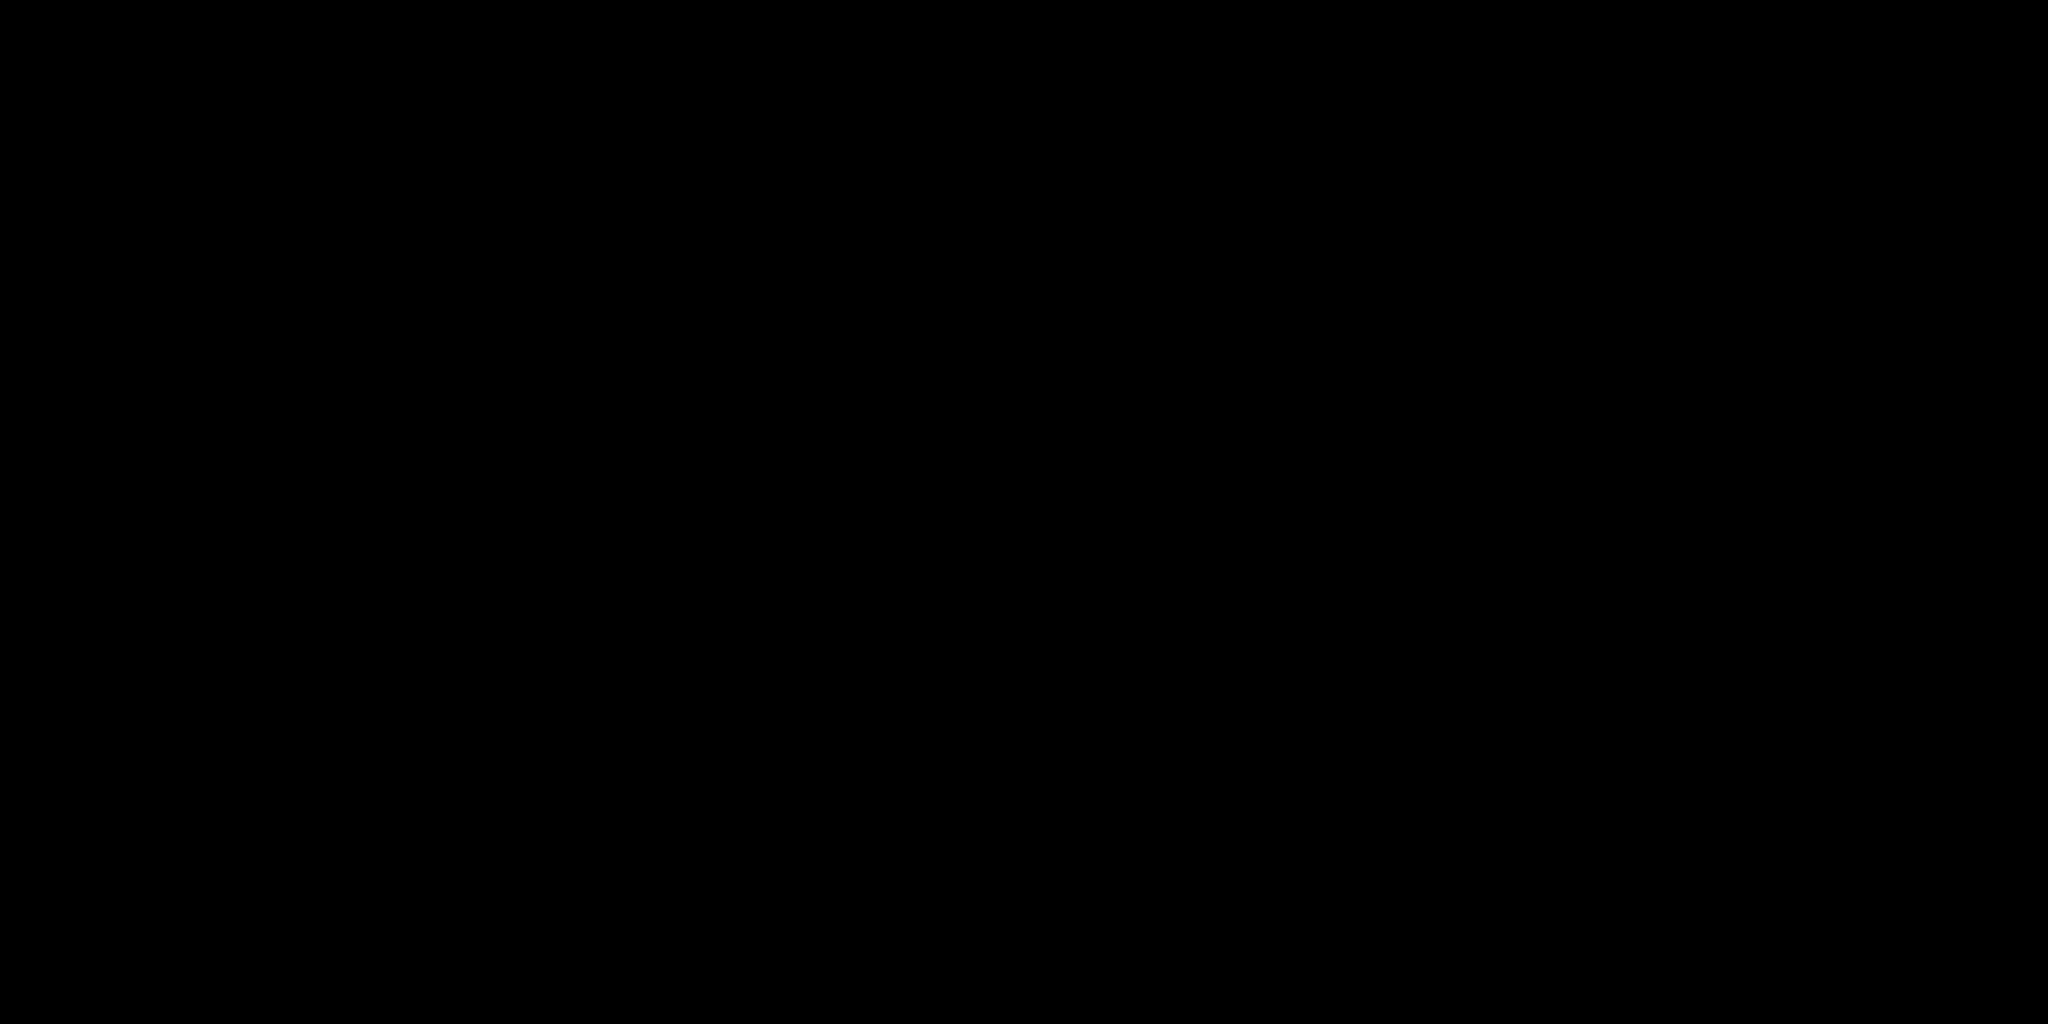

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(arr)

# Data Preprocessing

5032

## Input Pipeline

In [ ]:
output_files = [f for f in (exObj.images.get_files_list()) if f.endswith('.png')]

In [ ]:
train_x = [f for f in output_files if f.startswith('leftImg8bit/train')]
val_x = [f for f in output_files if f.startswith('leftImg8bit/val')]
# test_x = [f for f in output_files if f.startswith('leftImg8bit/test')]

In [ ]:
train_y_label = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/train') and f.endswith('gtFine_labelIds.png')]
val_y_label = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/val') and f.endswith('gtFine_labelIds.png')]
# test_y_label = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/test') and f.endswith('gtFine_labelIds.png')]

In [ ]:
train_y_color = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/train') and f.endswith('gtFine_color.png')]
val_y_color = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/val') and f.endswith('gtFine_color.png')]
# test_y_color = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/test') and f.endswith('gtFine_color.png')]

In [ ]:
train_y_label = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/train') and f.endswith('gtFine_labelIds.png')]
val_y_label = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/val') and f.endswith('gtFine_labelIds.png')]
# test_y_label = [f for f in exObj.segments.get_files_list() if f.startswith('gtFine/test') and f.endswith('gtFine_labelIds.png')]

In [ ]:
len(val_y_label)

500

[]

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

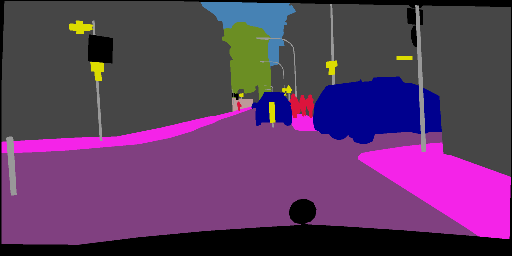

In [ ]:
i = cv2.imread(val_y_color[0])
i = cv2.resize(i,(512,256))
cv2_imshow(i)
# i.shape

In [ ]:
import numpy as np

In [ ]:
np.unique(i)

array([ 1,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33], dtype=uint8)

In [ ]:
import tensorflow as tf

class Preprocessor:
    def __init__(
            self,
            filepaths : list[str]
    ):
        self.filepaths = filepaths
        self.dataset = None

    def load_and_preprocess_image(self,file_path):
        image = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [128, 256])
        image = image / 255.0
        return image

    def get_dataset_iterator(self):
        if self.dataset:
            return self.dataset

        self.dataset = tf.data.Dataset.from_tensor_slices(self.filepaths)

        self.dataset = self.dataset.map(self.load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)

        # self.dataset = self.dataset.cache()
        # self.dataset = self.dataset.shuffle(buffer_size=1000)
        # self.dataset = self.dataset.batch(32)
        # self.dataset = self.dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        return self.dataset

In [ ]:
train_ds_x = Preprocessor(train_x).get_dataset_iterator()
val_ds_x = Preprocessor(val_x).get_dataset_iterator()
# test_ds_x = Preprocessor(test_x).get_dataset_iterator()


In [ ]:
# train_y,val_y = train_y_label,val_y_label
train_y,val_y = train_y_color,val_y_color



In [ ]:
train_ds_y = Preprocessor(train_y).get_dataset_iterator()
val_ds_y = Preprocessor(val_y).get_dataset_iterator()
# test_ds_y = Preprocessor(test_x).get_dataset_iterator()

In [ ]:
Preprocessor(train_x).load_and_preprocess_image(train_x[0])

<tf.Tensor: shape=(128, 256, 3), dtype=float32, numpy=
array([[[173.5 , 204.75, 202.5 ],
        [173.75, 206.25, 199.  ],
        [100.5 , 133.25, 140.25],
        ...,
        [ 37.  ,  49.75,  39.  ],
        [ 29.5 ,  41.5 ,  33.  ],
        [ 31.75,  43.  ,  33.25]],

       [[174.  , 203.75, 200.5 ],
        [173.5 , 203.  , 196.  ],
        [106.25, 142.5 , 138.75],
        ...,
        [ 40.  ,  54.75,  44.25],
        [ 36.25,  45.75,  38.75],
        [ 41.  ,  62.5 ,  51.25]],

       [[174.  , 205.  , 200.5 ],
        [168.  , 202.  , 199.25],
        [109.  , 145.75, 139.  ],
        ...,
        [ 62.  ,  86.  ,  65.  ],
        [ 39.25,  52.75,  39.5 ],
        [ 31.75,  45.25,  33.75]],

       ...,

       [[ 86.  , 104.  ,  85.  ],
        [ 82.75, 101.75,  85.  ],
        [ 85.  , 103.  ,  84.25],
        ...,
        [ 56.  ,  72.  ,  63.5 ],
        [ 55.  ,  70.25,  63.25],
        [ 54.25,  71.25,  63.  ]],

       [[ 85.  , 102.75,  84.75],
        [ 84.5 , 101.2

In [ ]:
dataset_train = tf.data.Dataset.zip(train_ds_x, train_ds_y)
dataset_val = tf.data.Dataset.zip(val_ds_x, val_ds_y)


In [ ]:
def optimize_datasets(dataset):
        dataset = dataset.cache()
        # dataset = dataset.shuffle(buffer_size=1000)
        dataset = dataset.batch(16)
        dataset = dataset.prefetch(buffer_size=2)
        return dataset

In [ ]:
dataset_train = optimize_datasets(dataset_train)
dataset_val = optimize_datasets(dataset_val)

In [ ]:
temp = dataset_train.as_numpy_iterator().next()

In [ ]:
import numpy as np

In [ ]:
x = (temp[0][2]*255).astype(np.int8)
y = (temp[1][2]*255).astype(np.int8)

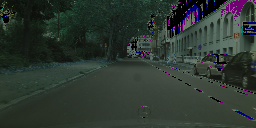

In [ ]:
cv2_imshow(x)

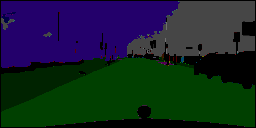

In [ ]:
cv2_imshow(y)

In [ ]:
temp[0][0]

array([[[ 46.25,  61.75,  46.25],
        [ 57.75,  74.  ,  59.25],
        [ 54.  ,  73.25,  59.25],
        ...,
        [123.25, 151.25, 146.75],
        [124.  , 154.  , 147.  ],
        [124.  , 153.75, 147.5 ]],

       [[ 18.75,  29.5 ,  28.25],
        [ 42.25,  62.75,  52.75],
        [ 47.25,  63.25,  50.25],
        ...,
        [121.  , 153.25, 146.5 ],
        [124.25, 153.25, 144.75],
        [127.  , 153.5 , 145.25]],

       [[ 47.5 ,  59.5 ,  47.5 ],
        [ 52.75,  69.5 ,  57.5 ],
        [ 46.75,  62.75,  50.25],
        ...,
        [123.5 , 150.  , 142.75],
        [124.5 , 151.5 , 146.5 ],
        [125.75, 154.  , 143.75]],

       ...,

       [[ 29.25,  41.75,  36.25],
        [ 29.  ,  41.75,  36.5 ],
        [ 30.25,  42.  ,  37.  ],
        ...,
        [ 45.5 ,  61.25,  52.25],
        [ 45.75,  62.  ,  55.  ],
        [ 47.  ,  63.  ,  55.25]],

       [[ 29.5 ,  41.  ,  35.5 ],
        [ 29.75,  41.  ,  36.25],
        [ 28.75,  41.75,  37.25],
        .

# NN

## Model

In [ ]:
img_x, img_y = 128,256

### Model 1

In [ ]:
inputs = keras.Input(shape = (img_x, img_y, 3))

x3_conv = layers.Conv2D(20,3,padding = "same", activation = 'linear')(inputs)

x3_relu = layers.ReLU()(x3_conv)

x5_conv = layers.Conv2D(20,5,padding = "same", activation = 'linear')(x3_relu)

x5_relu = layers.ReLU()(x5_conv)

x3_conv = layers.Conv2D(20,3,padding = "same", activation = 'linear')(x5_relu)

x3_relu = layers.ReLU()(x3_conv)

x5_conv = layers.Conv2D(20,5,padding = "same", activation = 'linear')(x3_relu)

x5_relu = layers.ReLU()(x5_conv)

x3_conv = layers.Conv2D(20,3,padding = "same", activation = 'linear')(x5_relu)

x3_relu = layers.ReLU()(x3_conv)

x5_conv = layers.Conv2D(20,5,padding = "same", activation = 'linear')(x3_relu)

x5_relu = layers.ReLU()(x5_conv)

x3_conv = layers.Conv2D(20,3,padding = "same", activation = 'linear')(x5_relu)

x3_relu = layers.ReLU()(x3_conv)

x5_conv = layers.Conv2D(20,5,padding = "same", activation = 'linear')(x3_relu)

x5_relu = layers.ReLU()(x5_conv)

x3_conv = layers.Conv2D(20,3,padding = "same", activation = 'linear')(x5_relu)

x3_relu = layers.ReLU()(x3_conv)

x5_conv =  layers.Conv2D(20,5,padding = "same", activation = 'linear')(x3_relu)
# feedback
x5_relu = layers.ReLU()(x5_conv + x5_relu)

x3_conv = layers.Conv2D(20,3,padding = "same", activation = 'linear')(x5_relu)

x3_relu = layers.ReLU()(x3_conv)

x5_conv =  layers.Conv2D(20,5,padding = "same", activation = 'linear')(x3_relu)
# feedback
x5_relu = layers.ReLU()(x5_conv + x5_relu)

# x = layers.MaxPool2D()(x5_relu)

# x = layers.Conv2D(40,(5,5))(x)

# x = layers.MaxPool2D()(x)

# x = layers.Conv2D(80,(5,5))(x)

# x = layers.MaxPool2D()(x)

# x = layers.Conv2D(160,(5,5))(x)

# x = layers.Conv2DTranspose(80,(5,5))(x)

# x = layers.Conv2DTranspose(40,(5,5))(x)

x5_relu = layers.Conv2D(10,1)(x5_relu)
x5_relu = layers.Conv2D(5,1)(x5_relu)
outputs = layers.Conv2D(1,1)(x5_relu)
# outputs = layers.Lambda(lambda x : tf.math.ceil(x), output_shape = (128,256,1))(outputs)

# outputs = layers.Softmax()(x5_relu)




## Model 2

In [ ]:
def feature_module():
    inputs = layers.Input(shape = (img_x,img_y,20))
    x3_conv = layers.Conv2D(20,3,padding = "same", activation = 'linear')(inputs)
    x3_relu = layers.ReLU()(x3_conv)
    x1_conv = layers.Conv2D(40,1,padding = "same", activation = 'linear')(x3_relu)
    x1_relu = layers.ReLU()(x1_conv)
    x1_conv = layers.Conv2D(80,1,padding = "same", activation = 'linear')(x1_relu)
    x1_relu = layers.ReLU()(x1_conv)
    x1_conv = layers.Conv2D(160,1,padding = "same", activation = 'linear')(x1_relu)
    x1_relu = layers.ReLU()(x1_conv)
    x1_conv = layers.Conv2D(80,1,padding = "same", activation = 'linear')(x1_relu)
    x1_relu = layers.ReLU()(x1_conv)
    x1_conv = layers.Conv2D(40,1,padding = "same", activation = 'linear')(x1_relu)
    x1_relu = layers.ReLU()(x1_conv)
    outputs = layers.Conv2D(20,1,padding = "same", activation = 'linear')(x1_relu)

    return keras.Model(inputs = inputs, outputs = outputs)

fm = feature_module()

In [ ]:
fm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 256, 20)]    0         
                                                                 
 conv2d (Conv2D)             (None, 128, 256, 20)      3620      
                                                                 
 re_lu (ReLU)                (None, 128, 256, 20)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 256, 40)      840       
                                                                 
 re_lu_1 (ReLU)              (None, 128, 256, 40)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 256, 80)      3280      
                                                                 
 re_lu_2 (ReLU)              (None, 128, 256, 80)      0     

In [ ]:
inputs = keras.Input(shape = (img_x, img_y, 3))
# x5_conv = layers.Conv2D(20,3,padding = "same", activation = 'linear')(inputs)
conv = layers.Conv2D(20,5, padding = "same", activation = 'relu')(inputs)
fm1 = feature_module()(conv)
relu = layers.ReLU()(fm1 + conv)
fm1 = feature_module()(relu)
relu = layers.ReLU()(fm1 + conv)
fm1 = feature_module()(relu)
relu = layers.ReLU()(fm1 + conv)
relu = layers.Conv2D(10,1,activation = 'relu')(relu)
relu = layers.Conv2D(5,1,activation = 'relu')(relu)
outputs = layers.Conv2D(1,1)(relu)


## Compiling

In [ ]:
model = keras.Model(inputs = inputs, outputs = outputs)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 256, 3)]        0         []                            
                                                                                                  
 conv2d_7 (Conv2D)           (None, 128, 256, 20)         1520      ['input_2[0][0]']             
                                                                                                  
 model_1 (Functional)        (None, 128, 256, 20)         37640     ['conv2d_7[0][0]']            
                                                                                                  
 tf.__operators__.add (TFOp  (None, 128, 256, 20)         0         ['model_1[0][0]',             
 Lambda)                                                             'conv2d_7[0][0]']      

In [ ]:
model.compile(
    optimizer='adam', loss='mean_squared_error', metrics=['mse'
])

In [ ]:
model.fit(
    x = dataset_train,
    epochs = 1,
    validation_data = dataset_val,

)

Epoch 1/10
186/186 [==============================] - 316s 2s/step - loss: 0.0568 - mse: 0.0568 - val_loss: 0.0462 - val_mse: 0.0462
Epoch 2/10
186/186 [==============================] - 69s 373ms/step - loss: 0.0464 - mse: 0.0464 - val_loss: 0.0473 - val_mse: 0.0473
Epoch 3/10
186/186 [==============================] - 69s 373ms/step - loss: 0.0457 - mse: 0.0457 - val_loss: 0.0472 - val_mse: 0.0472
Epoch 4/10
186/186 [==============================] - 68s 368ms/step - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0449 - val_mse: 0.0449
Epoch 5/10
186/186 [==============================] - 68s 368ms/step - loss: 0.0448 - mse: 0.0448 - val_loss: 0.0451 - val_mse: 0.0451
Epoch 6/10
186/186 [==============================] - 69s 372ms/step - loss: 0.0447 - mse: 0.0447 - val_loss: 0.0443 - val_mse: 0.0443
Epoch 7/10
186/186 [==============================] - 69s 372ms/step - loss: 0.0445 - mse: 0.0445 - val_loss: 0.0442 - val_mse: 0.0442
Epoch 8/10
186/186 [==============================] - 70s

In [ ]:
model.save("First_model.keras")

In [ ]:
dataset_train.as_numpy_iterator().next()[0].shape

(16, 128, 256, 3)

In [ ]:
x,y = dataset_train.as_numpy_iterator().next()

In [ ]:
x.shape

(16, 128, 256, 3)

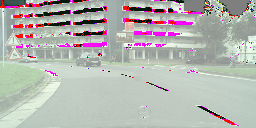

In [ ]:
keras.utils.array_to_img((x[0] * 255).astype(np.int8))

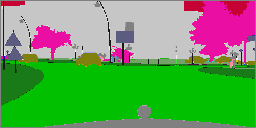

In [ ]:
keras.utils.array_to_img((y[0]*255).astype(np.int8))

In [ ]:
import numpy as np

In [ ]:
pred = model.predict(x)

1/1 [==============================] - 0s 211ms/step


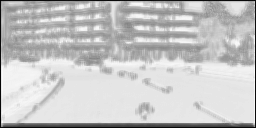

In [ ]:
keras.utils.array_to_img((pred[0]*255).astype(np.int8))

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

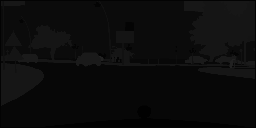

In [ ]:
cv2_imshow(y[0])

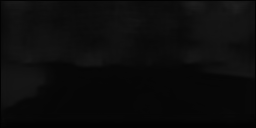

In [ ]:
cv2_imshow(pred[0])

In [ ]:
y[0]
\

array([[[ 3.,  3.,  3.],
        [ 3.,  3.,  3.],
        [ 3.,  3.,  3.],
        ...,
        [ 3.,  3.,  3.],
        [ 3.,  3.,  3.],
        [ 3.,  3.,  3.]],

       [[ 3.,  3.,  3.],
        [23., 23., 23.],
        [20., 20., 20.],
        ...,
        [21., 21., 21.],
        [21., 21., 21.],
        [ 3.,  3.,  3.]],

       [[ 3.,  3.,  3.],
        [23., 23., 23.],
        [20., 20., 20.],
        ...,
        [21., 21., 21.],
        [21., 21., 21.],
        [ 3.,  3.,  3.]],

       ...,

       [[ 3.,  3.,  3.],
        [ 7.,  7.,  7.],
        [ 7.,  7.,  7.],
        ...,
        [ 7.,  7.,  7.],
        [ 7.,  7.,  7.],
        [ 3.,  3.,  3.]],

       [[ 3.,  3.,  3.],
        [ 7.,  7.,  7.],
        [ 7.,  7.,  7.],
        ...,
        [ 7.,  7.,  7.],
        [ 7.,  7.,  7.],
        [ 3.,  3.,  3.]],

       [[ 3.,  3.,  3.],
        [ 3.,  3.,  3.],
        [ 3.,  3.,  3.],
        ...,
        [ 3.,  3.,  3.],
        [ 3.,  3.,  3.],
        [ 3.,  3.,  3.]]

In [ ]:
pred.max()

NameError: name 'pred' is not defined